In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [31]:
spark = SparkSession.builder.appName("Fraud Detection Model Evaluation").getOrCreate()


## Load Data and Models

Load the validation data and trained models to perform evaluation.

In [32]:
# Load validation data
input_path = "../data/features/fraud_features_v2.parquet"
df_model = spark.read.parquet(input_path)
val_df = df_model.filter((col("TX_DATE") >= "2023-06-01") & (col("TX_DATE") < "2023-07-01"))

# Load trained models
from pyspark.ml import PipelineModel
lr_model = PipelineModel.load("../models/lr_baseline_model")
gbt_model = PipelineModel.load("../models/gbt_baseline_model")
rf_model = PipelineModel.load("../models/rf_baseline_model")
print("Data and models loaded successfully!")


Data and models loaded successfully!


In [33]:
# Generate predictions on validation set
val_pred = lr_model.transform(val_df)
pred = gbt_model.transform(val_df)
rf_pred = rf_model.transform(val_df)
print("Predictions generated successfully!")
val_pred.select("TX_FRAUD", "probability", "prediction").show(5)
pred.select("TX_FRAUD", "probability", "prediction").show(5)
rf_pred.select("TX_FRAUD", "probability", "prediction").show(5)


Predictions generated successfully!
+--------+--------------------+----------+
|TX_FRAUD|         probability|prediction|
+--------+--------------------+----------+
|       0|[0.99978536182453...|       0.0|
|       1|[0.24325566066173...|       1.0|
|       0|[0.99999033257916...|       0.0|
|       0|[0.99998703625320...|       0.0|
|       0|[0.95695074777610...|       0.0|
+--------+--------------------+----------+
only showing top 5 rows
+--------+--------------------+----------+
|TX_FRAUD|         probability|prediction|
+--------+--------------------+----------+
|       0|[0.95344265742945...|       0.0|
|       1|[0.04364652142728...|       1.0|
|       0|[0.95353626545312...|       0.0|
|       0|[0.95353626545312...|       0.0|
|       0|[0.95318678251402...|       0.0|
+--------+--------------------+----------+
only showing top 5 rows
+--------+--------------------+----------+
|TX_FRAUD|         probability|prediction|
+--------+--------------------+----------+
|       0|[0.

In [34]:
# Model Evaluation Setup
# Function to evaluate a model
def evaluate_model(predictions, model_name):
    """Evaluate model and return metrics dictionary"""
    metrics = {'Model': model_name}
    
    # AUC
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol="TX_FRAUD",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )
    metrics['ROC-AUC'] = auc_evaluator.evaluate(predictions)
    
    # PR-AUC
    pr_evaluator = BinaryClassificationEvaluator(
        labelCol="TX_FRAUD",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR"
    )
    metrics['PR-AUC'] = pr_evaluator.evaluate(predictions)
    
    # Precision, Recall, F1
    for metric_name in ["precisionByLabel", "recallByLabel", "f1"]:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="TX_FRAUD",
            predictionCol="prediction",
            metricName=metric_name
        )
        metrics[metric_name] = evaluator.evaluate(predictions)
    
    return metrics, predictions

# Evaluate both models
print("=" * 60)
print("EVALUATING MODELS")
print("=" * 60)

lr_metrics, lr_pred = evaluate_model(val_pred, "Logistic Regression")
print(f"\nLogistic Regression:")
print(f"  ROC-AUC: {lr_metrics['ROC-AUC']:.6f}")
print(f"  PR-AUC:  {lr_metrics['PR-AUC']:.6f}")
print(f"  Precision: {lr_metrics['precisionByLabel']:.6f}")
print(f"  Recall:    {lr_metrics['recallByLabel']:.6f}")
print(f"  F1-Score:  {lr_metrics['f1']:.6f}")

gbt_metrics, gbt_pred = evaluate_model(pred, "Gradient Boosting Trees")
print(f"\nGradient Boosting Trees:")
print(f"  ROC-AUC: {gbt_metrics['ROC-AUC']:.6f}")
print(f"  PR-AUC:  {gbt_metrics['PR-AUC']:.6f}")
print(f"  Precision: {gbt_metrics['precisionByLabel']:.6f}")
print(f"  Recall:    {gbt_metrics['recallByLabel']:.6f}")
print(f"  F1-Score:  {gbt_metrics['f1']:.6f}")

rf_metrics, rf_pred = evaluate_model(rf_pred, "Random Forest")
print(f"\nRandom Forest:")
print(f"  ROC-AUC: {rf_metrics['ROC-AUC']:.6f}")
print(f"  PR-AUC:  {rf_metrics['PR-AUC']:.6f}")
print(f"  Precision: {rf_metrics['precisionByLabel']:.6f}")
print(f"  Recall:    {rf_metrics['recallByLabel']:.6f}")
print(f"  F1-Score:  {rf_metrics['f1']:.6f}")

# Create metrics DataFrame
metrics_df = pd.DataFrame([lr_metrics, gbt_metrics, rf_metrics])
print("\n" + "=" * 60)
print("METRICS SUMMARY")
print("=" * 60)
print(metrics_df.to_string(index=False))

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


EVALUATING MODELS

Logistic Regression:
  ROC-AUC: 0.980836
  PR-AUC:  0.973316
  Precision: 0.994024
  Recall:    0.998791
  F1-Score:  0.993719

Gradient Boosting Trees:
  ROC-AUC: 0.980046
  PR-AUC:  0.968730
  Precision: 0.994009
  Recall:    0.988931
  F1-Score:  0.985369

Random Forest:
  ROC-AUC: 0.979861
  PR-AUC:  0.981657
  Precision: 0.993762
  Recall:    1.000000
  F1-Score:  0.994523

METRICS SUMMARY
                  Model  ROC-AUC   PR-AUC  precisionByLabel  recallByLabel       f1
    Logistic Regression 0.980836 0.973316          0.994024       0.998791 0.993719
Gradient Boosting Trees 0.980046 0.968730          0.994009       0.988931 0.985369
          Random Forest 0.979861 0.981657          0.993762       1.000000 0.994523


## Model Evaluation Visualizations

This section provides comprehensive visualizations to compare the performance of different models across various metrics.


### 1. Comprehensive Metrics Comparison

This visualization compares all key metrics (ROC-AUC, PR-AUC, Precision, Recall, F1-Score) side-by-side across all models. This provides a quick overview of how each model performs across different evaluation criteria.


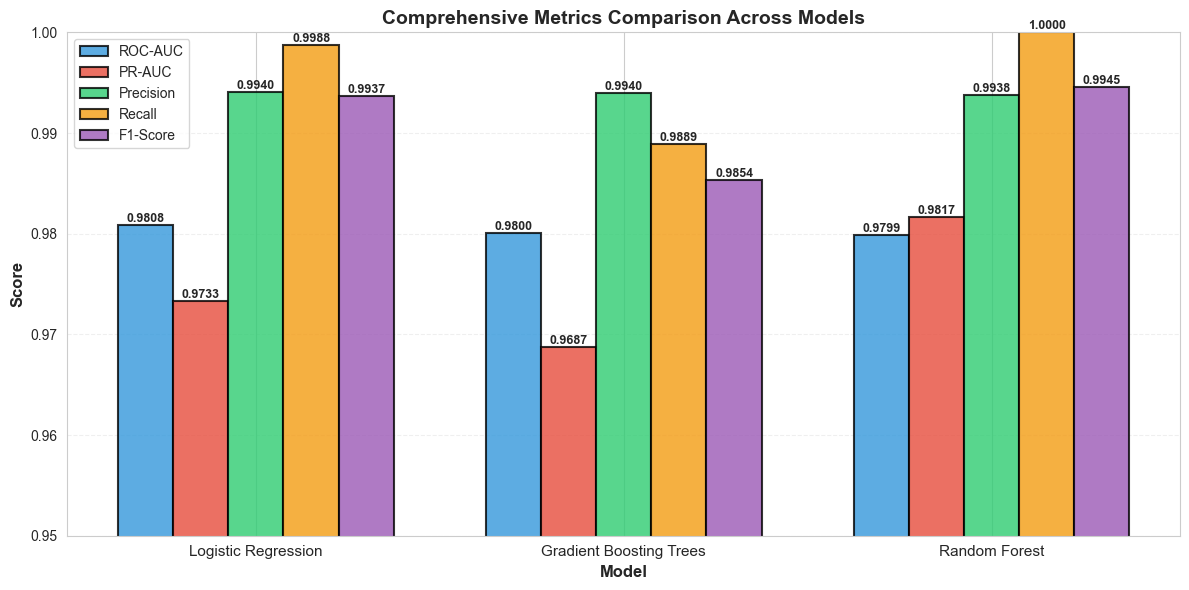

In [35]:
# Comprehensive Metrics Comparison
models = metrics_df['Model'].values
metrics_to_plot = {
    'ROC-AUC': metrics_df['ROC-AUC'].values,
    'PR-AUC': metrics_df['PR-AUC'].values,
    'Precision': metrics_df['precisionByLabel'].values,
    'Recall': metrics_df['recallByLabel'].values,
    'F1-Score': metrics_df['f1'].values
}

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.15
multiplier = 0

colors_metrics = {
    'ROC-AUC': '#3498db',
    'PR-AUC': '#e74c3c',
    'Precision': '#2ecc71',
    'Recall': '#f39c12',
    'F1-Score': '#9b59b6'
}

for metric_name, values in metrics_to_plot.items():
    offset = width * multiplier
    bars = ax.bar(x + offset, values, width, label=metric_name, 
                  color=colors_metrics[metric_name], alpha=0.8, edgecolor='black', linewidth=1.5)
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    multiplier += 1

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Metrics Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models, fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.set_ylim([0.95, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### 2. ROC-AUC Comparison

**ROC-AUC (Receiver Operating Characteristic - Area Under Curve)** measures the ability of the model to distinguish between classes. A score of 1.0 indicates perfect classification, while 0.5 suggests random performance. This metric is particularly useful for binary classification problems with imbalanced datasets.


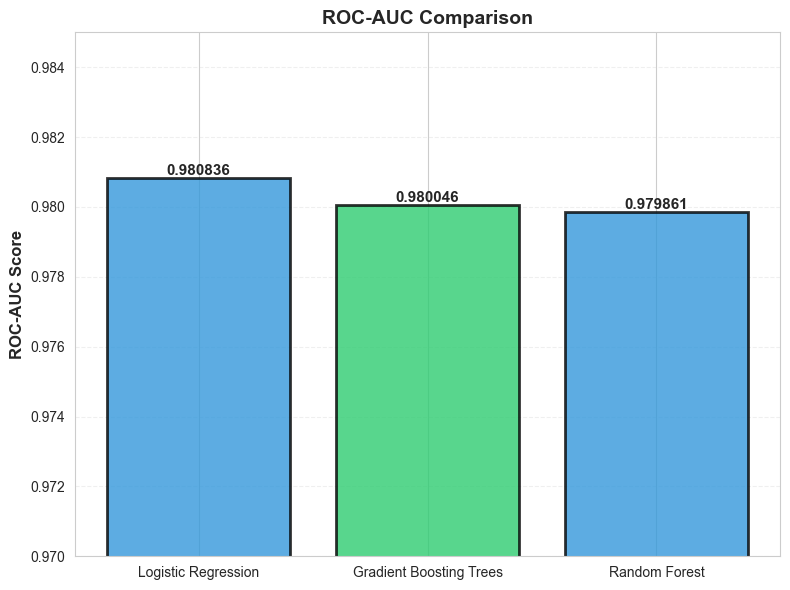

In [36]:
# ROC-AUC Comparison
fig, ax = plt.subplots(figsize=(8, 6))
bars_auc = ax.bar(models, metrics_df['ROC-AUC'], 
                  color=['#3498db', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.97, 0.985])
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars_auc, metrics_df['ROC-AUC']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()


### 3. PR-AUC Comparison

**PR-AUC (Precision-Recall Area Under Curve)** is often preferred over ROC-AUC for imbalanced datasets. It focuses on the performance of the positive class (fraud in our case) and is more informative when the negative class (non-fraud) dominates the dataset. Higher PR-AUC indicates better performance in detecting fraud cases.


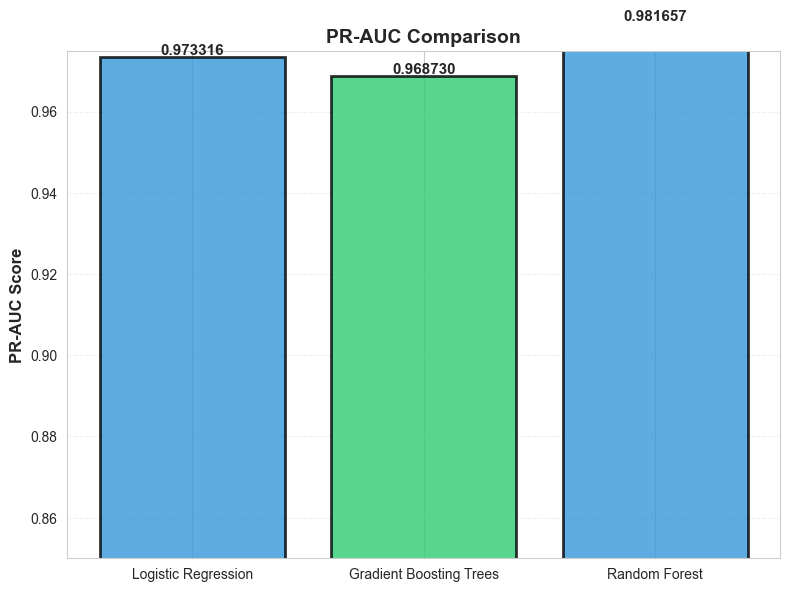

In [37]:
# PR-AUC Comparison
fig, ax = plt.subplots(figsize=(8, 6))
bars_pr = ax.bar(models, metrics_df['PR-AUC'], 
                 color=['#3498db', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('PR-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.85, 0.975])
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars_pr, metrics_df['PR-AUC']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()


### 4. Precision, Recall, and F1-Score Comparison

- **Precision**: The proportion of positive predictions that are actually correct (True Positives / (True Positives + False Positives))
- **Recall**: The proportion of actual positives that were correctly identified (True Positives / (True Positives + False Negatives))
- **F1-Score**: The harmonic mean of precision and recall, providing a balanced metric

These metrics help understand the trade-offs between minimizing false positives (precision) and false negatives (recall) in fraud detection.


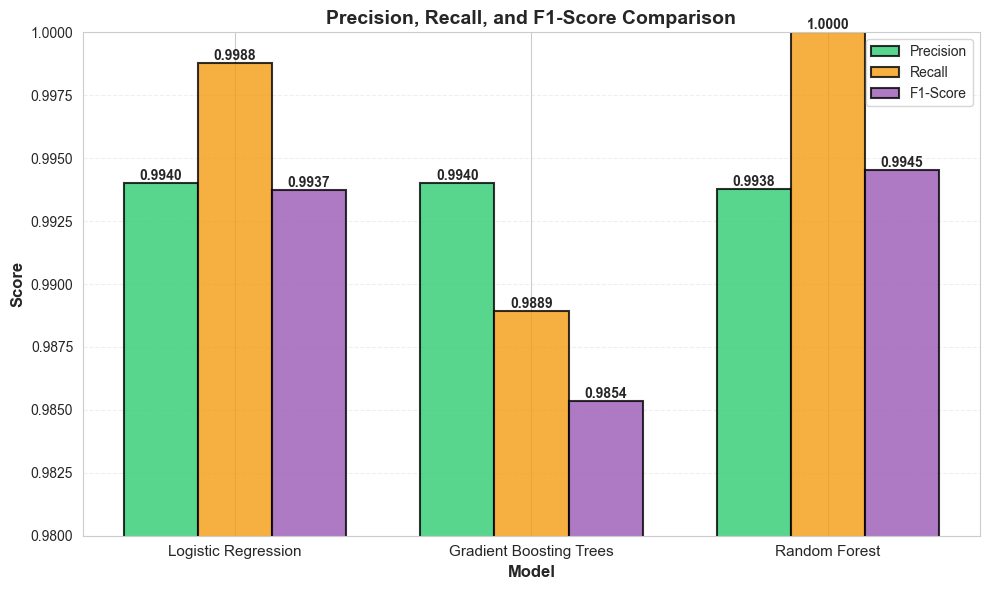

In [38]:
# Precision, Recall, F1 Comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(models))
width_bar = 0.25
metrics_class = ['Precision', 'Recall', 'F1-Score']
values_class = [
    metrics_df['precisionByLabel'].values,
    metrics_df['recallByLabel'].values,
    metrics_df['f1'].values
]
colors_class = ['#2ecc71', '#f39c12', '#9b59b6']
for i, (metric_name, values, color) in enumerate(zip(metrics_class, values_class, colors_class)):
    bars = ax.bar(x_pos + i*width_bar, values, width_bar, label=metric_name,
                  color=color, alpha=0.8, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Precision, Recall, and F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width_bar)
ax.set_xticklabels(models, fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0.98, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### 5. Confusion Matrices

Confusion matrices show the actual vs predicted classifications, breaking down the performance into:
- **True Negatives (TN)**: Correctly predicted non-fraud transactions
- **False Positives (FP)**: Non-fraud transactions incorrectly flagged as fraud
- **False Negatives (FN)**: Fraud transactions missed by the model
- **True Positives (TP)**: Correctly identified fraud transactions

This visualization helps identify if a model is biased towards over-predicting fraud (high FP) or missing fraud cases (high FN).


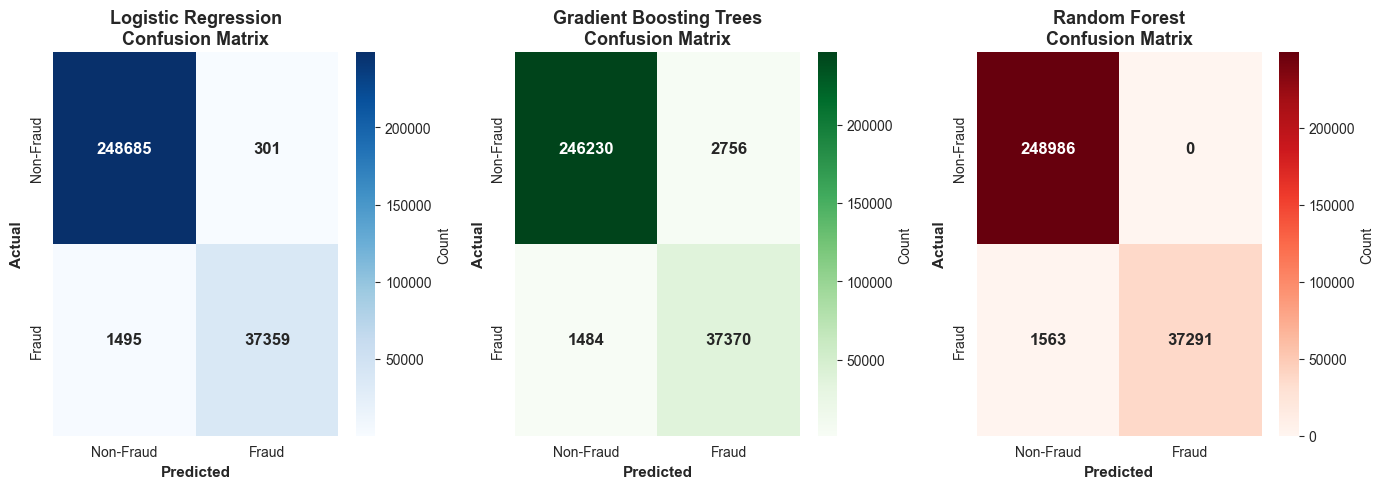

In [39]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Logistic Regression Confusion Matrix
ax1 = axes[0]
lr_cm_pd = lr_pred.select("TX_FRAUD", "prediction").toPandas()
lr_cm = confusion_matrix(lr_cm_pd["TX_FRAUD"], lr_cm_pd["prediction"])
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Logistic Regression\nConfusion Matrix', fontsize=13, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=11, fontweight='bold')

# GBT Confusion Matrix
ax2 = axes[1]
gbt_cm_pd = gbt_pred.select("TX_FRAUD", "prediction").toPandas()
gbt_cm = confusion_matrix(gbt_cm_pd["TX_FRAUD"], gbt_cm_pd["prediction"])
sns.heatmap(gbt_cm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Gradient Boosting Trees\nConfusion Matrix', fontsize=13, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')

# RF Confusion Matrix
ax3 = axes[2]
rf_cm_pd = rf_pred.select("TX_FRAUD", "prediction").toPandas()
rf_cm = confusion_matrix(rf_cm_pd["TX_FRAUD"], rf_cm_pd["prediction"])
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Reds', ax=ax3,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax3.set_title('Random Forest\nConfusion Matrix', fontsize=13, fontweight='bold')
ax3.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=11, fontweight='bold')

# Set the title for the entire figure


plt.tight_layout()
plt.show()


### 6. Performance Radar Chart

A radar chart provides a visual comparison of all metrics simultaneously. Each axis represents a different metric, and the shape formed by connecting the points for each model shows its overall performance profile. Models with larger shapes perform better across all metrics.


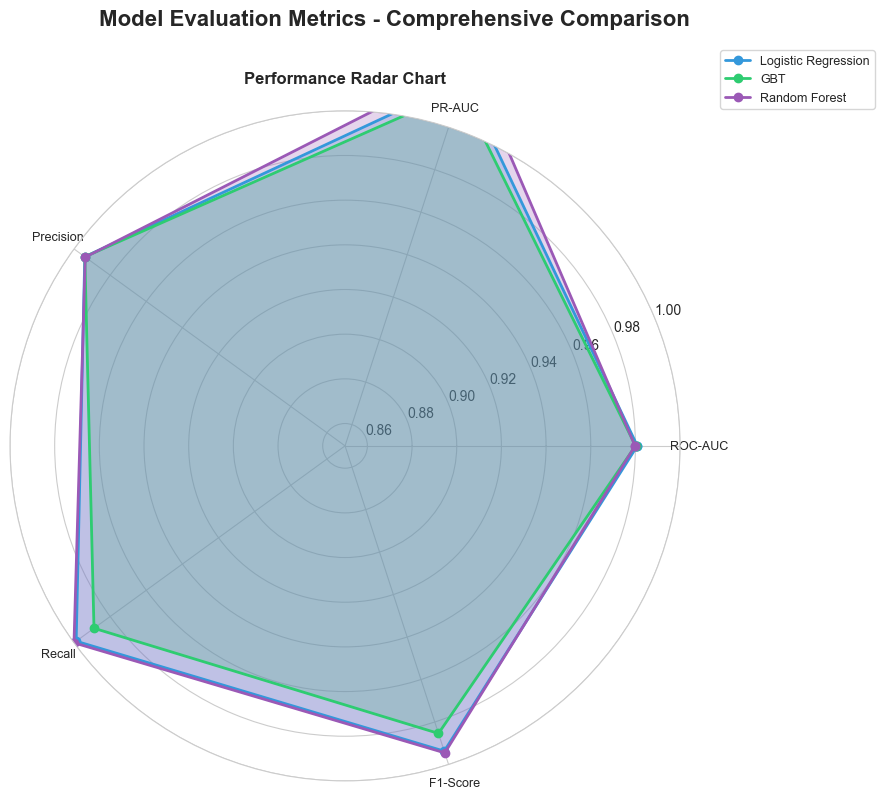

In [40]:
# Radar/Spider Chart Style Comparison
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
categories = ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Prepare values for radar chart
lr_values_normalized = [
    metrics_df.loc[0, 'ROC-AUC'],
    metrics_df.loc[0, 'PR-AUC'] * 1.05,  # Scale PR-AUC for visibility
    metrics_df.loc[0, 'precisionByLabel'],
    metrics_df.loc[0, 'recallByLabel'],
    metrics_df.loc[0, 'f1']
]
gbt_values_normalized = [
    metrics_df.loc[1, 'ROC-AUC'],
    metrics_df.loc[1, 'PR-AUC'] * 1.05,
    metrics_df.loc[1, 'precisionByLabel'],
    metrics_df.loc[1, 'recallByLabel'],
    metrics_df.loc[1, 'f1']
]
rf_values_normalized = [
    metrics_df.loc[2, 'ROC-AUC'],
    metrics_df.loc[2, 'PR-AUC'] * 1.05,
    metrics_df.loc[2, 'precisionByLabel'],
    metrics_df.loc[2, 'recallByLabel'],
    metrics_df.loc[2, 'f1']
]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

lr_values_normalized += lr_values_normalized[:1]
gbt_values_normalized += gbt_values_normalized[:1]
rf_values_normalized += rf_values_normalized[:1]

ax.plot(angles, lr_values_normalized, 'o-', linewidth=2, label='Logistic Regression', color='#3498db')
ax.fill(angles, lr_values_normalized, alpha=0.25, color='#3498db')
ax.plot(angles, gbt_values_normalized, 'o-', linewidth=2, label='GBT', color='#2ecc71')
ax.fill(angles, gbt_values_normalized, alpha=0.25, color='#2ecc71')
ax.plot(angles, rf_values_normalized, 'o-', linewidth=2, label='Random Forest', color='#9b59b6')
ax.fill(angles, rf_values_normalized, alpha=0.25, color='#9b59b6')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=9)
ax.set_ylim([0.85, 1.0])
ax.set_title('Performance Radar Chart', fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax.grid(True)

plt.suptitle('Model Evaluation Metrics - Comprehensive Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### 7. Summary: Best Performing Model per Metric

This summary identifies which model performs best for each individual metric, helping to make an informed decision based on the specific requirements of the fraud detection system.


In [41]:
# Detailed Metrics Summary
print("=" * 60)
print("DETAILED METRICS SUMMARY")
print("=" * 60)
print(f"\nBest ROC-AUC: {metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'Model']} ({metrics_df['ROC-AUC'].max():.6f})")
print(f"Best PR-AUC:  {metrics_df.loc[metrics_df['PR-AUC'].idxmax(), 'Model']} ({metrics_df['PR-AUC'].max():.6f})")
print(f"Best Precision: {metrics_df.loc[metrics_df['precisionByLabel'].idxmax(), 'Model']} ({metrics_df['precisionByLabel'].max():.6f})")
print(f"Best Recall:    {metrics_df.loc[metrics_df['recallByLabel'].idxmax(), 'Model']} ({metrics_df['recallByLabel'].max():.6f})")
print(f"Best F1-Score:  {metrics_df.loc[metrics_df['f1'].idxmax(), 'Model']} ({metrics_df['f1'].max():.6f})")
print("=" * 60)


DETAILED METRICS SUMMARY

Best ROC-AUC: Logistic Regression (0.980836)
Best PR-AUC:  Random Forest (0.981657)
Best Precision: Logistic Regression (0.994024)
Best Recall:    Random Forest (1.000000)
Best F1-Score:  Random Forest (0.994523)


## Model Evaluation Conclusion

Three classification models were evaluated for the fraud detection task: **Logistic Regression**, **Gradient Boosting Trees**, and **Random Forest**, using a time-based validation split to reflect real-world deployment conditions.

---

### Comparative Performance Analysis

* **Logistic Regression** demonstrated the most balanced performance across precision, recall, and F1-score. It achieved high recall while maintaining a low false positive rate, resulting in stable and interpretable predictions.

* **Gradient Boosting Trees** achieved comparable recall but produced a higher number of false positives. This indicates a more aggressive decision strategy that may increase operational cost in practical fraud detection systems.

* **Random Forest** achieved a recall of **1.0**, meaning no fraudulent transactions were missed. However, this came at the cost of a significant increase in false positives. The model tends to over-predict the fraud class, suggesting overfitting to minority-class patterns rather than robust generalization.

---

### Interpretation of Recall = 1.0 in Random Forest

While a perfect recall may appear desirable, in the context of fraud detection it can be misleading. A model that flags nearly all suspicious transactions as fraud can overwhelm downstream investigation processes and significantly increase operational cost. Therefore, recall must be evaluated together with precision and false positive rate rather than in isolation.

---

### Baseline Model Selection

Considering both predictive performance and practical applicability, **Logistic Regression is selected as the preferred baseline model** due to:

* A superior balance between precision and recall
* Lower false positive rate
* Robust behavior under temporal validation
* High interpretability and ease of deployment

This model provides a reliable reference point for future improvements and more advanced modeling approaches.

---

### Final Conclusion

> Although more complex tree-based models can achieve higher recall, Logistic Regression offers the most stable and cost-effective baseline for fraud detection in this dataset.
> Future model enhancements should focus on improving recall **without disproportionately increasing false positives**, potentially through advanced feature engineering, cost-sensitive learning, or sequence-based modeling.

---

